In [1]:
import time
import psycopg2
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from finance.utilities import utils
from finance.science.utilities import lstm_utils, modeling_utils, options_utils, science_utils

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get stock data

In [2]:
start_date = '2015-01-01'
end_date = '2019-06-20'
query = f'''
            with
            tickers as (
                select distinct
                      ticker
                    , sector
                    , industry
                from nasdaq.listed_stocks
                where   ticker !~ '[\^.~]'
                    and character_length(ticker) between 1 and 4
                    and ticker in ('KO')
                limit 30
                )
            , lagged_prices as (
                select
                      s.symbol
                    , s.market_datetime
                    , avg(s.open) over (partition by s.symbol order by s.market_datetime rows between 31 preceding and 1 preceding) as mean
                    , s.open as open_0
                    , lag(s.open,  1) over (w) as open_1
                    , lag(s.open,  2) over (w) as open_2
                    , lag(s.open,  3) over (w) as open_3
                    , lag(s.open,  4) over (w) as open_4
                    , lag(s.open,  5) over (w) as open_5
                    , lag(s.open,  6) over (w) as open_6
                    , lag(s.open,  7) over (w) as open_7
                    , lag(s.open,  8) over (w) as open_8
                    , lag(s.open,  9) over (w) as open_9
                    , lag(s.open, 10) over (w) as open_10
                    , lag(s.open, 11) over (w) as open_11
                    , lag(s.open, 12) over (w) as open_12
                    , lag(s.open, 13) over (w) as open_13
                    , lag(s.open, 14) over (w) as open_14
                    , lag(s.open, 15) over (w) as open_15
                    , lag(s.open, 16) over (w) as open_16
                    , lag(s.open, 17) over (w) as open_17
                    , lag(s.open, 18) over (w) as open_18
                    , lag(s.open, 19) over (w) as open_19
                    , lag(s.open, 20) over (w) as open_20
                    , lag(s.open, 21) over (w) as open_21
                    , lag(s.open, 22) over (w) as open_22
                    , lag(s.open, 23) over (w) as open_23
                    , lag(s.open, 24) over (w) as open_24
                    , lag(s.open, 25) over (w) as open_25
                    , lag(s.open, 26) over (w) as open_26
                    , lag(s.open, 27) over (w) as open_27
                    , lag(s.open, 28) over (w) as open_28
                    , lag(s.open, 29) over (w) as open_29
                    , lag(s.open, 30) over (w) as open_30
                from dbt.stocks as s
                inner join tickers as t
                    on t.ticker = s.symbol
                where s.market_datetime between '{start_date}' and '{end_date}'
                window w as (partition by s.symbol order by s.market_datetime)
                )
            , raw_deviations as (
                select
                    symbol
                  , market_datetime
                  , abs(open_0  - mean) as abs_dev_0
                  , abs(open_1  - mean) as abs_dev_1
                  , abs(open_2  - mean) as abs_dev_2
                  , abs(open_3  - mean) as abs_dev_3
                  , abs(open_4  - mean) as abs_dev_4
                  , abs(open_5  - mean) as abs_dev_5
                  , abs(open_6  - mean) as abs_dev_6
                  , abs(open_7  - mean) as abs_dev_7
                  , abs(open_8  - mean) as abs_dev_8
                  , abs(open_9  - mean) as abs_dev_9
                  , abs(open_10 - mean) as abs_dev_10
                  , abs(open_11 - mean) as abs_dev_11
                  , abs(open_12 - mean) as abs_dev_12
                  , abs(open_13 - mean) as abs_dev_13
                  , abs(open_14 - mean) as abs_dev_14
                  , abs(open_15 - mean) as abs_dev_15
                  , abs(open_16 - mean) as abs_dev_16
                  , abs(open_17 - mean) as abs_dev_17
                  , abs(open_18 - mean) as abs_dev_18
                  , abs(open_19 - mean) as abs_dev_19
                  , abs(open_20 - mean) as abs_dev_20
                  , abs(open_21 - mean) as abs_dev_21
                  , abs(open_22 - mean) as abs_dev_22
                  , abs(open_23 - mean) as abs_dev_23
                  , abs(open_24 - mean) as abs_dev_24
                  , abs(open_25 - mean) as abs_dev_25
                  , abs(open_26 - mean) as abs_dev_26
                  , abs(open_27 - mean) as abs_dev_27
                  , abs(open_28 - mean) as abs_dev_28
                  , abs(open_29 - mean) as abs_dev_29
                  , abs(open_30 - mean) as abs_dev_30
                from lagged_prices
                )
            , deviations as (
              select
                  symbol
                , market_datetime
                , (  abs_dev_0
                   + abs_dev_1
                   + abs_dev_2
                   + abs_dev_3
                   + abs_dev_4
                   + abs_dev_5
                   + abs_dev_6
                   + abs_dev_7
                   + abs_dev_8
                   + abs_dev_9
                   + abs_dev_10
                   + abs_dev_11
                   + abs_dev_12
                   + abs_dev_13
                   + abs_dev_14
                   + abs_dev_15
                   + abs_dev_16
                   + abs_dev_17
                   + abs_dev_18
                   + abs_dev_19
                   + abs_dev_20
                   + abs_dev_21
                   + abs_dev_22
                   + abs_dev_23
                   + abs_dev_24
                   + abs_dev_25
                   + abs_dev_26
                   + abs_dev_27
                   + abs_dev_28
                   + abs_dev_29
                   + abs_dev_30
                 ) / 31 as mean_abs_dev
              from raw_deviations
              )
            , final as (
                select
                    symbol
                  , market_datetime
                  , mean_abs_dev as target
                  , lag(mean_abs_dev,  1) over (w) as mean_abs_dev_1
                  , lag(mean_abs_dev,  2) over (w) as mean_abs_dev_2
                  , lag(mean_abs_dev,  3) over (w) as mean_abs_dev_3
                  , lag(mean_abs_dev,  4) over (w) as mean_abs_dev_4
                  , lag(mean_abs_dev,  5) over (w) as mean_abs_dev_5
                  , lag(mean_abs_dev,  6) over (w) as mean_abs_dev_6
                  , lag(mean_abs_dev,  7) over (w) as mean_abs_dev_7
                  , lag(mean_abs_dev,  8) over (w) as mean_abs_dev_8
                  , lag(mean_abs_dev,  9) over (w) as mean_abs_dev_9
                  , lag(mean_abs_dev, 10) over (w) as mean_abs_dev_10
                  , lag(mean_abs_dev, 11) over (w) as mean_abs_dev_11
                  , lag(mean_abs_dev, 12) over (w) as mean_abs_dev_12
                  , lag(mean_abs_dev, 13) over (w) as mean_abs_dev_13
                  , lag(mean_abs_dev, 14) over (w) as mean_abs_dev_14
                  , lag(mean_abs_dev, 15) over (w) as mean_abs_dev_15
                  , lag(mean_abs_dev, 16) over (w) as mean_abs_dev_16
                  , lag(mean_abs_dev, 17) over (w) as mean_abs_dev_17
                  , lag(mean_abs_dev, 18) over (w) as mean_abs_dev_18
                  , lag(mean_abs_dev, 19) over (w) as mean_abs_dev_19
                  , lag(mean_abs_dev, 20) over (w) as mean_abs_dev_20
                  , lag(mean_abs_dev, 21) over (w) as mean_abs_dev_21
                  , lag(mean_abs_dev, 22) over (w) as mean_abs_dev_22
                  , lag(mean_abs_dev, 23) over (w) as mean_abs_dev_23
                  , lag(mean_abs_dev, 24) over (w) as mean_abs_dev_24
                  , lag(mean_abs_dev, 25) over (w) as mean_abs_dev_25
                  , lag(mean_abs_dev, 26) over (w) as mean_abs_dev_26
                  , lag(mean_abs_dev, 27) over (w) as mean_abs_dev_27
                  , lag(mean_abs_dev, 28) over (w) as mean_abs_dev_28
                  , lag(mean_abs_dev, 29) over (w) as mean_abs_dev_29
                  , lag(mean_abs_dev, 30) over (w) as mean_abs_dev_30
                from deviations
                window w as (partition by symbol order by market_datetime)
                )
            select *
            from final
            where mean_abs_dev_30 is not null
            order by 1,2
            '''

df = utils.query_db(query=query)
df = df[~df.isna()]
df.head()

,symbol,market_datetime,target,mean_abs_dev_1,mean_abs_dev_2,mean_abs_dev_3,mean_abs_dev_4,mean_abs_dev_5,mean_abs_dev_6,mean_abs_dev_7,...,mean_abs_dev_21,mean_abs_dev_22,mean_abs_dev_23,mean_abs_dev_24,mean_abs_dev_25,mean_abs_dev_26,mean_abs_dev_27,mean_abs_dev_28,mean_abs_dev_29,mean_abs_dev_30
0,KO,2015-03-31,0.859282,0.850916,0.834464,0.810957,0.810604,0.781374,0.752112,0.713590,...,0.506868,0.483486,0.500989,0.527700,0.566191,0.579594,0.572830,0.562612,0.548606,0.532817
1,KO,2015-04-01,0.858293,0.859282,0.850916,0.834464,0.810957,0.810604,0.781374,0.752112,...,0.521311,0.506868,0.483486,0.500989,0.527700,0.566191,0.579594,0.572830,0.562612,0.548606
2,KO,2015-04-02,0.857440,0.858293,0.859282,0.850916,0.834464,0.810957,0.810604,0.781374,...,0.540832,0.521311,0.506868,0.483486,0.500989,0.527700,0.566191,0.579594,0.572830,0.562612
3,KO,2015-04-06,0.853309,0.857440,0.858293,0.859282,0.850916,0.834464,0.810957,0.810604,...,0.539230,0.540832,0.521311,0.506868,0.483486,0.500989,0.527700,0.566191,0.579594,0.572830
4,KO,2015-04-07,0.825317,0.853309,0.857440,0.858293,0.859282,0.850916,0.834464,0.810957,...,0.522612,0.539230,0.540832,0.521311,0.506868,0.483486,0.500989,0.527700,0.566191,0.579594


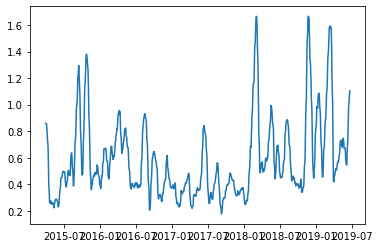

In [3]:
plt.plot(df['market_datetime'], df['target'])
plt.show()

### Clean data

In [4]:
SYMBOL = 'symbol'
TARGET = 'target'

COLS_TO_IGNORE = [
    'market_datetime',
    SYMBOL,
    TARGET,
]

In [5]:
df = science_utils.encode_one_hot(df, [SYMBOL])
df.head(10)

,symbol,market_datetime,target,mean_abs_dev_1,mean_abs_dev_2,mean_abs_dev_3,mean_abs_dev_4,mean_abs_dev_5,mean_abs_dev_6,mean_abs_dev_7,...,mean_abs_dev_22,mean_abs_dev_23,mean_abs_dev_24,mean_abs_dev_25,mean_abs_dev_26,mean_abs_dev_27,mean_abs_dev_28,mean_abs_dev_29,mean_abs_dev_30,symbol_KO
0,KO,2015-03-31,0.859282,0.850916,0.834464,0.810957,0.810604,0.781374,0.752112,0.713590,...,0.483486,0.500989,0.527700,0.566191,0.579594,0.572830,0.562612,0.548606,0.532817,1
1,KO,2015-04-01,0.858293,0.859282,0.850916,0.834464,0.810957,0.810604,0.781374,0.752112,...,0.506868,0.483486,0.500989,0.527700,0.566191,0.579594,0.572830,0.562612,0.548606,1
2,KO,2015-04-02,0.857440,0.858293,0.859282,0.850916,0.834464,0.810957,0.810604,0.781374,...,0.521311,0.506868,0.483486,0.500989,0.527700,0.566191,0.579594,0.572830,0.562612,1
3,KO,2015-04-06,0.853309,0.857440,0.858293,0.859282,0.850916,0.834464,0.810957,0.810604,...,0.540832,0.521311,0.506868,0.483486,0.500989,0.527700,0.566191,0.579594,0.572830,1
4,KO,2015-04-07,0.825317,0.853309,0.857440,0.858293,0.859282,0.850916,0.834464,0.810957,...,0.539230,0.540832,0.521311,0.506868,0.483486,0.500989,0.527700,0.566191,0.579594,1
5,KO,2015-04-08,0.805525,0.825317,0.853309,0.857440,0.858293,0.859282,0.850916,0.834464,...,0.522612,0.539230,0.540832,0.521311,0.506868,0.483486,0.500989,0.527700,0.566191,1
6,KO,2015-04-09,0.786420,0.805525,0.825317,0.853309,0.857440,0.858293,0.859282,0.850916,...,0.503059,0.522612,0.539230,0.540832,0.521311,0.506868,0.483486,0.500989,0.527700,1
7,KO,2015-04-10,0.739605,0.786420,0.805525,0.825317,0.853309,0.857440,0.858293,0.859282,...,0.474506,0.503059,0.522612,0.539230,0.540832,0.521311,0.506868,0.483486,0.500989,1
8,KO,2015-04-13,0.696639,0.739605,0.786420,0.805525,0.825317,0.853309,0.857440,0.858293,...,0.461842,0.474506,0.503059,0.522612,0.539230,0.540832,0.521311,0.506868,0.483486,1
9,KO,2015-04-14,0.649917,0.696639,0.739605,0.786420,0.805525,0.825317,0.853309,0.857440,...,0.492404,0.461842,0.474506,0.503059,0.522612,0.539230,0.540832,0.521311,0.506868,1


### Train lstm

In [6]:
size = int(round(len(df)/2, -2))

train = df.head(size)
test = df.tail(int(size/2))

Batch 1, Epoch 0, Loss 145.58213806152344
Batch 1, Epoch 25, Loss 109.45696258544922
Batch 1, Epoch 50, Loss 43.995548248291016
Batch 1, Epoch 75, Loss 41.288795471191406
Batch 1, Epoch 100, Loss 37.180885314941406
Batch 1, Epoch 125, Loss 32.9827880859375
Batch 1, Epoch 150, Loss 27.153398513793945
Batch 1, Epoch 175, Loss 21.646949768066406
Batch 1, Epoch 200, Loss 18.334407806396484
Batch 1, Epoch 225, Loss 15.311267852783203
Batch 2, Epoch 0, Loss 11.550407409667969
Batch 2, Epoch 25, Loss 8.915803909301758
Batch 2, Epoch 50, Loss 8.580937385559082
Batch 2, Epoch 75, Loss 8.468528747558594
Batch 2, Epoch 100, Loss 8.23202896118164
Batch 2, Epoch 125, Loss 8.002384185791016
Batch 2, Epoch 150, Loss 7.711067199707031
Batch 2, Epoch 175, Loss 7.543178558349609
Batch 2, Epoch 200, Loss 7.149747848510742
Batch 2, Epoch 225, Loss 6.879578590393066


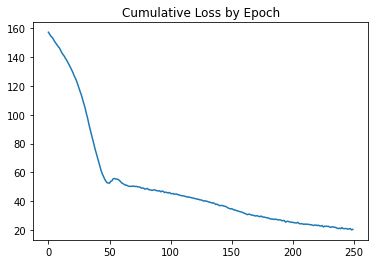

In [7]:
model = lstm_utils.TorchLSTM(
    x=train.drop(COLS_TO_IGNORE, axis=1),
    y=train[TARGET],
    n_layers=2,
    n_training_batches=2,
    batch_size=int(size/2),
    n_epochs=250,
    hidden_shape=1000,
    dropout=0.1,
    learning_rate=.0001,
    seed=44,
)

model.fit()

model.x = test.drop(COLS_TO_IGNORE, axis=1)
prediction = model.prediction_df

In [8]:
PREDICTION = 'prediction'

res = test[COLS_TO_IGNORE].join(prediction)
res.head()

,market_datetime,symbol,target,mean_abs_dev_1,mean_abs_dev_2,mean_abs_dev_3,mean_abs_dev_4,mean_abs_dev_5,mean_abs_dev_6,mean_abs_dev_7,...,mean_abs_dev_23,mean_abs_dev_24,mean_abs_dev_25,mean_abs_dev_26,mean_abs_dev_27,mean_abs_dev_28,mean_abs_dev_29,mean_abs_dev_30,symbol_KO,prediction
814,2018-06-22,KO,0.657419,0.680708,0.694735,0.679615,0.688824,0.661145,0.635848,0.604173,...,0.967752,0.985349,0.993496,0.958335,0.920062,0.873434,0.841478,0.814745,1,0.720921
815,2018-06-25,KO,0.630312,0.657419,0.680708,0.694735,0.679615,0.688824,0.661145,0.635848,...,0.943923,0.967752,0.985349,0.993496,0.958335,0.920062,0.873434,0.841478,1,0.690959
816,2018-06-26,KO,0.619334,0.630312,0.657419,0.680708,0.694735,0.679615,0.688824,0.661145,...,0.922789,0.943923,0.967752,0.985349,0.993496,0.958335,0.920062,0.873434,1,0.650007
817,2018-06-27,KO,0.594984,0.619334,0.630312,0.657419,0.680708,0.694735,0.679615,0.688824,...,0.896389,0.922789,0.943923,0.967752,0.985349,0.993496,0.958335,0.920062,1,0.612334
818,2018-06-28,KO,0.549823,0.594984,0.619334,0.630312,0.657419,0.680708,0.694735,0.679615,...,0.863247,0.896389,0.922789,0.943923,0.967752,0.985349,0.993496,0.958335,1,0.576637


### Evaluate predictions

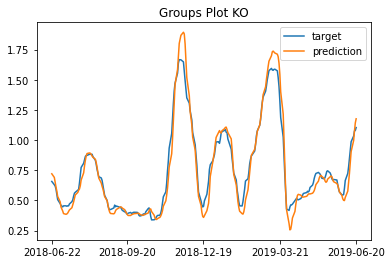

In [9]:
science_utils.plot_groups(res, SYMBOL, [TARGET, PREDICTION])